In [18]:
import numpy as np
from PIL import Image
from torchvision.datasets import CIFAR10


In [19]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import homogeneity_score
import pandas as pd

In [20]:
%%capture
!pip install git+https://github.com/openai/CLIP.git

In [21]:
testdata = CIFAR10('.', train=False, download=True)

Files already downloaded and verified


In [22]:
img = [testdata[i][0] for i in range(4000)]
lab = [testdata[i][1] for i in range(4000)]
#emb = ibed.to_embeddings(img)
#emb.shape

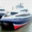

In [23]:
img[1]

In [8]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import homogeneity_score, adjusted_mutual_info_score, adjusted_rand_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score

def calculate_metrics(estimator, X, labels_true, labels_pred):
    return {
        'inertia': estimator[-1].inertia_,
        'homogeneity_score': homogeneity_score(labels_true, labels_pred),
        'adjusted_mutual_info_score': adjusted_mutual_info_score(labels_true, labels_pred),
        'adjusted_rand_score': adjusted_rand_score(labels_true, labels_pred),
        'silhouette_score': silhouette_score(X, labels_pred),
        'calinski_harabasz_score': calinski_harabasz_score(X, labels_pred),
        'davies_bouldin_score': davies_bouldin_score(X, labels_pred),
    }

In [7]:
import torch
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [8]:
device =  "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 156MiB/s]


In [10]:
images = torch.vstack([preprocess(i).unsqueeze(0).to(device) for i in img])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# text = clip.tokenize(classes).to(device)

with torch.no_grad():
    image_features = model.encode_image(images)
    # text_features = model.encode_text(text)
    
    # logits_per_image, logits_per_text = model(image, text)
    # probs = logits_per_image.softmax(dim=-1).cpu().numpy()



In [63]:
image_features.shape

torch.Size([4000, 512])

In [15]:
emb=image_features.cpu()
kmeans = KMeans(n_clusters=10)
estimator = make_pipeline(StandardScaler(), kmeans).fit(emb)
metrics = calculate_metrics(estimator, emb, lab, estimator[-1].labels_)
metrics

{'adjusted_mutual_info_score': 0.7748981432984217,
 'adjusted_rand_score': 0.6636655640987321,
 'calinski_harabasz_score': 218.6637475849545,
 'davies_bouldin_score': 2.653610559355119,
 'homogeneity_score': 0.7659262647958331,
 'inertia': 1457636.174088264,
 'silhouette_score': 0.10261536052649468}

# **STart HDBSCAN**

In [1]:
!pip install hdbscan
!pip install kneed


In [2]:
import hdbscan
import seaborn as sns

ON CLip data

In [51]:
embeds=image_features.cpu()

In [52]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, gen_min_span_tree=True)
clusterer.fit(embeds)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=3)

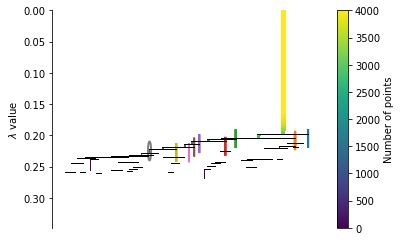

In [18]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())


In [20]:
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

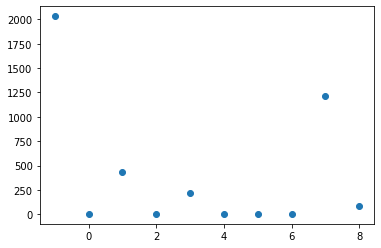

In [22]:
import matplotlib.pyplot as plt

unique, counts = np.unique(clusterer.labels_, return_counts=True)
plt.scatter(unique,counts)
    

In [29]:
homogeneity_score(lab, clusterer.labels_),

(0.22948793143583743,)

# Trial to improve

# Identified 8 clusters

On the first embedding

In [ ]:
embeds=emb

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(embeds)

In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())


Just 2 clusters :(

# Plain DBSCAN

In [32]:
from sklearn.cluster import DBSCAN


In [33]:
embeds=image_features.cpu()

In [34]:
 db = DBSCAN(eps=0.5, min_samples=5).fit_predict(embeds)


In [35]:
np.unique(db)

array([-1])

# parameter tuning for eps


6.137924849556914


<Figure size 360x360 with 0 Axes>

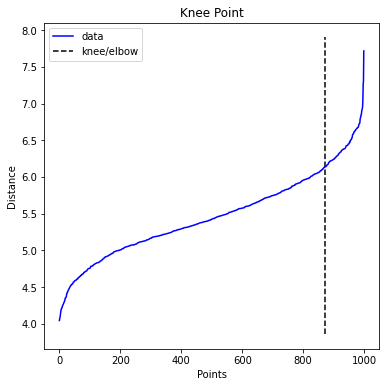

In [ ]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(embeds)
distances, indices = neighbors.kneighbors(embeds)
distances = np.sort(distances[:,10], axis=0)
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(distances[knee.knee])

# minsamples via silhouette skor 

Optimal number of min_samples based on silhouette score: [14, 15, 16, 17]


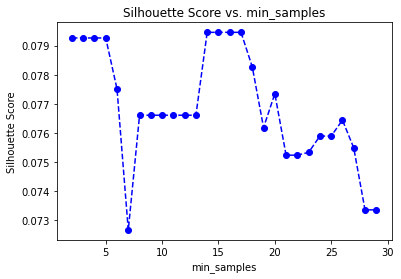

In [ ]:
from sklearn.metrics import silhouette_score 
from sklearn.cluster import DBSCAN

def get_dbscan_score(data, center):
    '''
    
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Silhouette Score for DBSCAN
    '''
    #instantiate kmeans
    dbscan = DBSCAN(eps= 6.137924849556914, min_samples=center)

    # Then fit the model to your data using the fit method
    model = dbscan.fit(embeds)
    
    # Calculate Silhoutte Score

    score = silhouette_score(embeds, model.labels_, metric='euclidean')
    
    return score

scores = []
centers = list(range(2,30))

for center in centers:
    scores.append(get_dbscan_score(embeds, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('min_samples');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs. min_samples');

df3 = pd.DataFrame(centers,columns=['min_samples'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of min_samples based on silhouette score:', df4['min_samples'].tolist())

# Rund DBSCAN with optimal params

In [ ]:

sampls=df4['min_samples'].tolist()
for i in sampls:

  db = DBSCAN(eps=6.137924849556914, min_samples=i).fit(embeds)
  unique, counts = np.unique(db.labels_, return_counts=True)
  #plt.figure(count)
  #plt.scatter(unique,counts)
  #count=count+1
  print(unique,i)

[-1  0] 14
[-1  0] 15
[-1  0] 16
[-1  0] 17


In [ ]:
xx=np.linspace(3.5,5,num=20)

count=0
for i in xx:

    db = DBSCAN(eps=i, min_samples=5).fit(embeds)
    unique, counts = np.unique(db.labels_, return_counts=True)
    plt.figure(count)
    plt.scatter(unique,counts)
    count=count+1
    #print(unique,i)

# Dendrogram for Hierarchical Clustering


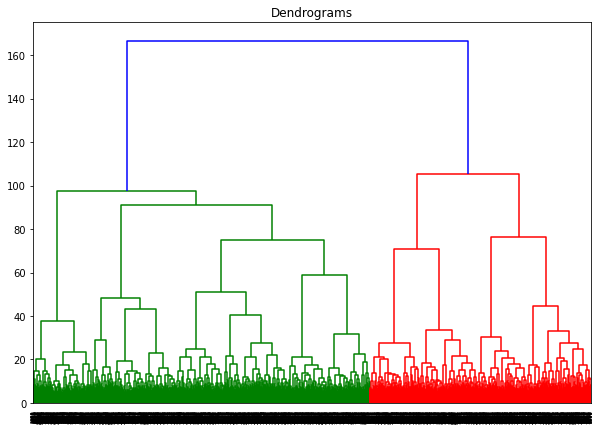

In [40]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(emb, method='ward'))

# agglomorative clustering

In [36]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
cluster.fit_predict(embeds)

array([4, 5, 5, ..., 6, 6, 2])

In [39]:
homogeneity_score(lab, cluster.labels_)

0.6874901478163556

In [37]:
labels_true=lab
labels_pred=cluster.labels_
print('homogeneity_score', homogeneity_score(labels_true, labels_pred))
print('adjusted_mutual_info_score', adjusted_mutual_info_score(labels_true, labels_pred))
print('adjusted_rand_score', adjusted_rand_score(labels_true, labels_pred))
print('silhouette_score', silhouette_score(embeds, labels_pred))
print('calinski_harabasz_score', calinski_harabasz_score(embeds, labels_pred))
print( 'davies_bouldin_score', davies_bouldin_score(embeds, labels_pred))


homogeneity_score 0.6874901478163556
adjusted_mutual_info_score 0.6895324203930949
adjusted_rand_score 0.6093960381662009
silhouette_score 0.09113929721801071
calinski_harabasz_score 202.02970356244532
davies_bouldin_score 2.8100693551329896


# compare with kmeans

In [38]:
kmeans = KMeans(n_clusters=10)
estimator = make_pipeline(StandardScaler(), kmeans).fit(embeds)
metrics = calculate_metrics(estimator, embeds, lab, estimator[-1].labels_)
metrics

{'adjusted_mutual_info_score': 0.7761471481471008,
 'adjusted_rand_score': 0.6660960855667203,
 'calinski_harabasz_score': 218.76852442114873,
 'davies_bouldin_score': 2.655855012120718,
 'homogeneity_score': 0.7673031038909538,
 'inertia': 1457630.4565313845,
 'silhouette_score': 0.10281304604885838}

# Non-embedded

In [58]:
!mkdir cifar

In [59]:
!tar -xvf cifar-10-python.tar.gz --directory cifar

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pickle



def unpickle(file):
 '''Load byte data from file'''
 with open(file, 'rb') as f:
  data = pickle.load(f, encoding='latin-1')
  return data


def load_cifar10_data(data_dir):
 '''Return train_data, train_labels, test_data, test_labels
 The shape of data is 32 x 32 x3'''
 train_data = None
 train_labels = []

 for i in range(1, 6):
  data_dic = unpickle(data_dir + "/data_batch_{}".format(i))
  if i == 1:
   train_data = data_dic['data']
  else:
   train_data = np.vstack((train_data, data_dic['data']))
  train_labels += data_dic['labels']

 test_data_dic = unpickle(data_dir + "/test_batch")
 test_data = test_data_dic['data']
 test_labels = test_data_dic['labels']

 train_data = train_data.reshape((len(train_data), 3, 32, 32))
 train_data = np.rollaxis(train_data, 1, 4)
 train_labels = np.array(train_labels)

 test_data = test_data.reshape((len(test_data), 3, 32, 32))
 test_data = np.rollaxis(test_data, 1, 4)
 test_labels = np.array(test_labels)

 return train_data, train_labels, test_data, test_labels

#data_dir = 'cifar-10-batches-py'
data_dir='cifar/cifar-10-batches-py'

train_data, train_labels, test_data, test_labels = load_cifar10_data(data_dir)

print(train_data.shape)
print(train_labels.shape)

print(test_data.shape)
print(test_labels.shape)

# In order to check where the data shows an image correctly
label_encoding = unpickle(data_dir + "/batches.meta")
label_encoding=label_encoding['label_names']
print(label_encoding[0])


(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)
airplane


In [31]:
reshaped_test=test_data[0:4000].reshape(4000,3072)

In [35]:
embeds=reshaped_test
lab=test_labels[:4000]

#DBSCAN

In [65]:
from sklearn.cluster import DBSCAN

In [66]:
 db = DBSCAN(eps=5, min_samples=5).fit_predict(embeds)


In [67]:
np.unique(db)

array([-1])

# HDBSCAN

In [38]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, gen_min_span_tree=False)
clusterer.fit(embeds)

HDBSCAN(min_cluster_size=3)

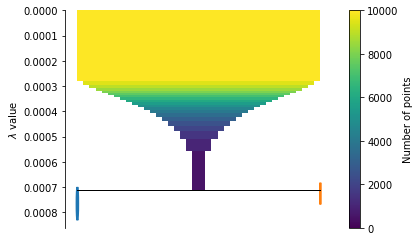

In [57]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())


# Agglomerative clustering


In [33]:
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
clusterer.fit_predict(embeds)

array([3, 1, 9, ..., 4, 6, 9])

In [36]:
homogeneity_score(lab, clusterer.labels_)

0.08229119398811294

In [12]:
labels_true=lab
labels_pred=clusterer.labels_
print('homogeneity_score', homogeneity_score(labels_true, labels_pred))
print('adjusted_mutual_info_score', adjusted_mutual_info_score(labels_true, labels_pred))
print('adjusted_rand_score', adjusted_rand_score(labels_true, labels_pred))
print('silhouette_score', silhouette_score(embeds, labels_pred))
print('calinski_harabasz_score', calinski_harabasz_score(embeds, labels_pred))
print( 'davies_bouldin_score', davies_bouldin_score(embeds, labels_pred))


homogeneity_score 0.06397225909244
adjusted_mutual_info_score 0.06363798851257568
adjusted_rand_score 0.03008355585211854
silhouette_score 0.02509789244726792
calinski_harabasz_score 509.1994218933728
davies_bouldin_score 3.3834031112152756


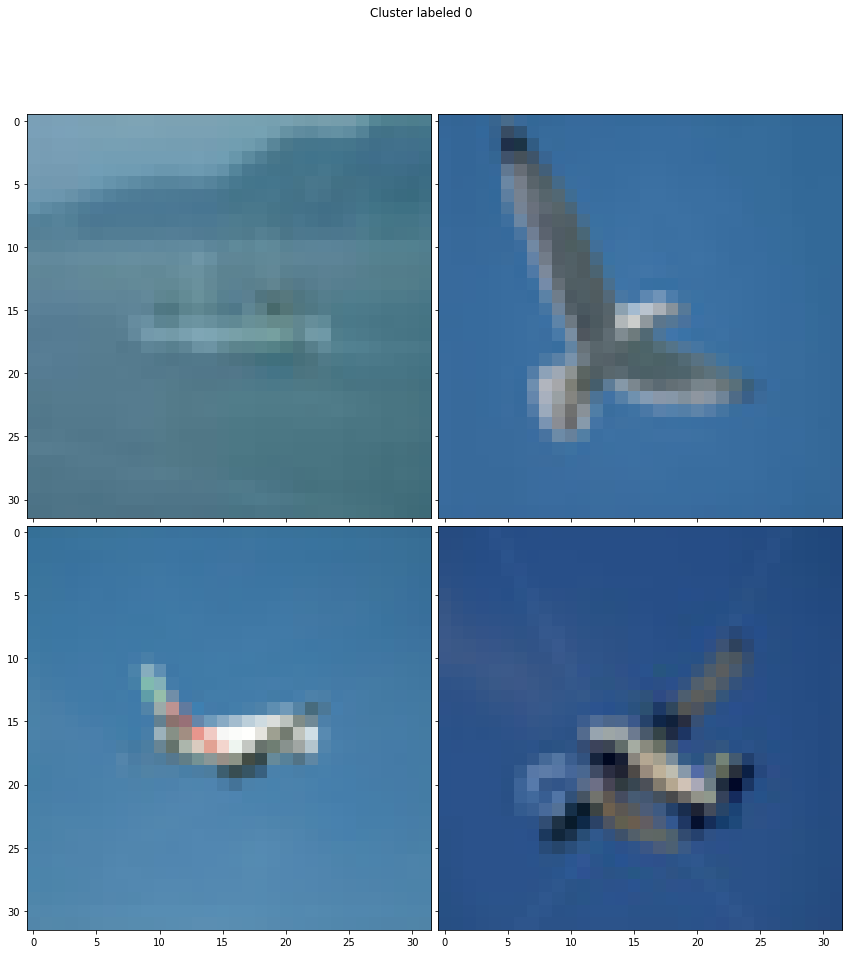

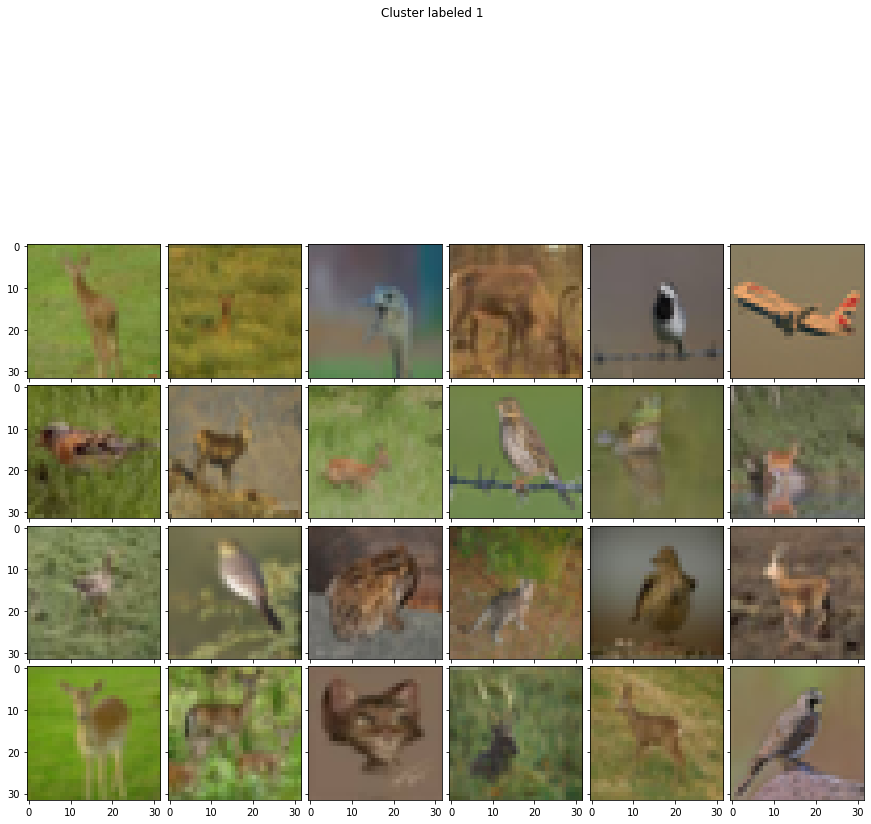

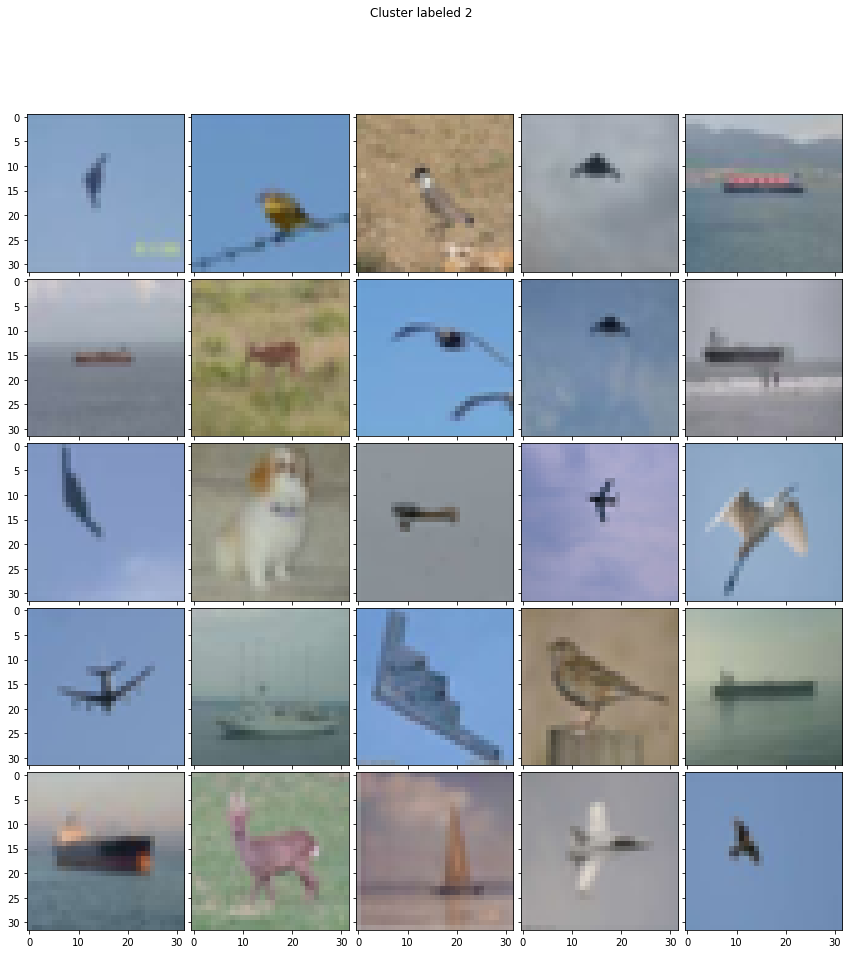

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

rng = np.random.default_rng()
for cluster in range(10):
    all_idx = np.where(clusterer.labels_ == cluster)[0]
    idx = rng.choice(all_idx, min(25, len(all_idx)), replace=False)
    images = [img[i] for i in idx]
    if len(images) == 0:
      continue
    nrows = int(np.sqrt(len(images)))
    ncols = len(images)//nrows
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle(f"Cluster labeled {cluster}")
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.1)
    for ax, im in zip(grid, images):
        ax.imshow(im)
    # break
    fig.savefig(f"cluster_{cluster}_images.png", dpi=500, bbox_inches="tight")

plt.show()

In [48]:
cluster=2
all_idx = np.where(clusterer.labels_ == cluster)[0]


(407,)